# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = "../data/train.p"
validation_file = "../data/valid.p"
testing_file = "../data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Basic Summary of the Data Set

In [2]:
import numpy as np

# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import pandas as pd
# Visualizations will be shown in the notebook.
%matplotlib inline

In [4]:
# Sign names
signnames = pd.read_csv('signnames.csv', index_col=0)

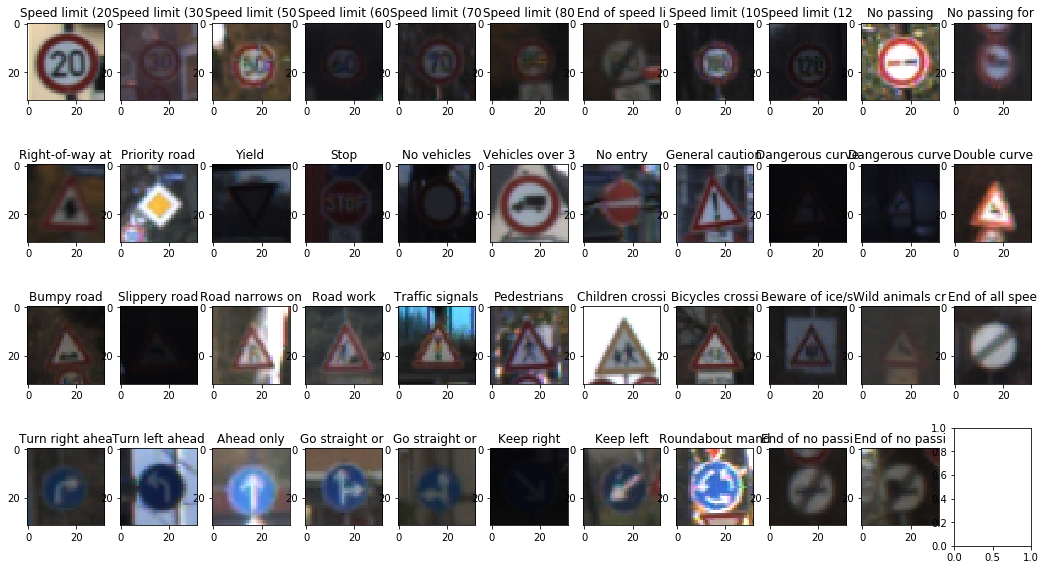

In [20]:
def get_signname(sign_id, signnames):
    return signnames['SignName'].loc[sign_id]

def show_example_all_labels(X, y, signnames, figsize=(18, 10)):
    unique_y, unique_y_idx = np.unique(y, return_index=True)
    ncols = 11
    fig, axs = plt.subplots(ncols=ncols, nrows=int(np.ceil(len(unique_y) / ncols)), figsize=figsize)
    for ax, y, img in zip(axs.flat, unique_y, X[unique_y_idx]):
        if img.shape[-1] == 1:
            ax.imshow(img[:, :, 0], cmap='gray')
        else:
            ax.imshow(img)
        ax.set_title(get_signname(y, signnames)[:15])
        
show_example_all_labels(X_train, y_train, signnames)

In [6]:
y_df_train = pd.DataFrame({'y': y_train, 'type': 'train'})
y_df_valid = pd.DataFrame({'y': y_valid, 'type': 'valid'})
y_df_test = pd.DataFrame({'y': y_test, 'type': 'test'})
y_df = pd.concat([y_df_train, y_df_valid, y_df_test])

counts = y_df.groupby(['type', 'y']).size().unstack().T
#counts

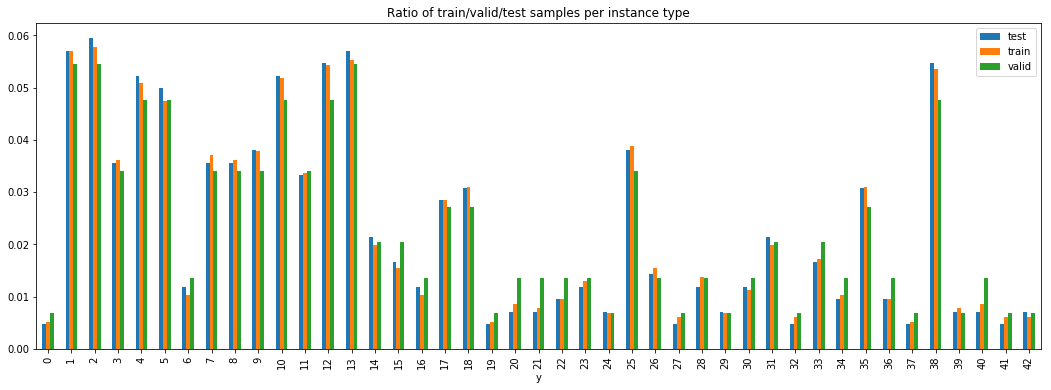

In [7]:
ratios = counts / counts.sum()
ratios = ratios.merge(signnames, left_on='y', right_index=True)
ratios.plot(title='Ratio of train/valid/test samples per instance type', 
            figsize=(18, 6), kind='bar')

----

## Step 2: Design and Test a Model Architecture

### Pre-process

In [8]:
def norm(data):
    # must convert to a larger int type before subtracting
    result = (data.astype(np.int16) - 128) / 128.0
    assert(result.min() >= -1.0 and result.max() <= 1.0)
    return result

def gray(data):
    return data.mean(axis=-1, keepdims=1)

X_train_norm = norm(X_train)
X_valid_norm = norm(X_valid)
X_test_norm = norm(X_test)

X_train_norm_gray = gray(X_train_norm)
X_valid_norm_gray = gray(X_valid_norm)
X_test_norm_gray = gray(X_test_norm)

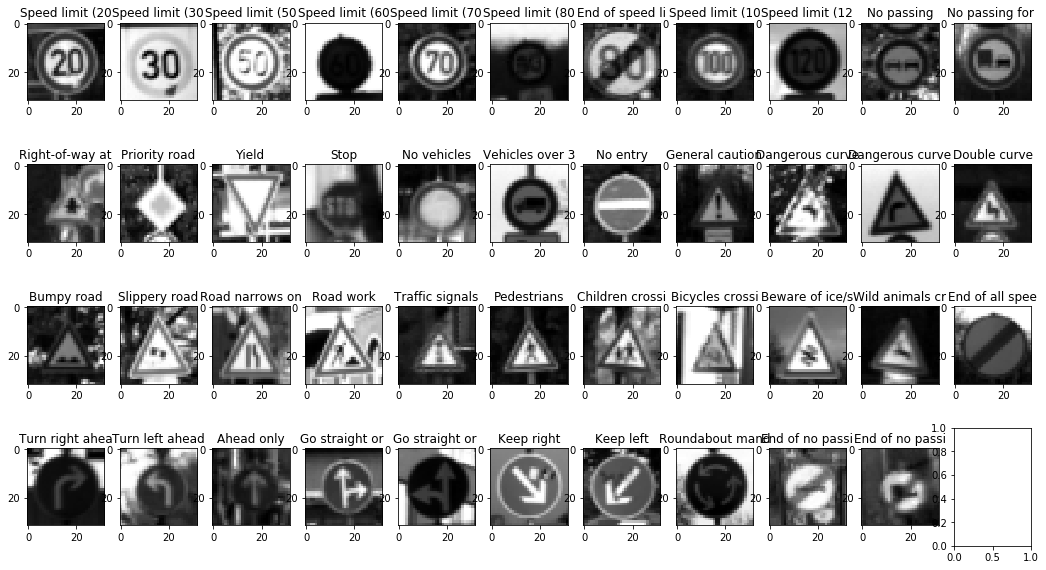

In [9]:
from sklearn.utils import shuffle
X_s, y_s = shuffle(X_train_norm_gray, y_train)

show_example_all_labels((X_s + 1.0) / 2.0, y_s, signnames)

### Model Architecture

In [10]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

num_of_y = len(np.unique(y_train))

def LeNet(x, input_channels, dropout_keep_prob, pool_type, weights_sigma, l2_reg_scale):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = weights_sigma # 0.1
    
    assert(input_channels in [1, 3])
    
    if l2_reg_scale and l2_reg_scale > 0.0:
        regularizer = tf.contrib.layers.l2_regularizer(scale=l2_reg_scale)
    else:
        regularizer = None
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    wc1 = tf.get_variable(initializer=tf.truncated_normal((5, 5, input_channels, 6), mean=mu, stddev=sigma), 
                      name='wc1', regularizer=regularizer) # (height, width, input_depth, output_depth)
    bc1 = tf.Variable(tf.zeros(6), name='bc1')
    layer1 = tf.nn.conv2d(x, wc1, (1, 1, 1, 1), 'VALID') + bc1

    # Activation.
    layer1 = tf.nn.relu(layer1)
    
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    if pool_type == 'max':
        pool1 = tf.nn.max_pool(layer1, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1), padding='VALID')
    else:
        pool1 = tf.nn.avg_pool(layer1, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1), padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    wc2 = tf.get_variable(initializer=tf.truncated_normal((5, 5, 6, 16), mean=mu, stddev=sigma), 
                      name='wc2', regularizer=regularizer)
    bc2 = tf.Variable(tf.zeros(16), name='bc2')
    layer2 = tf.nn.conv2d(pool1, wc2, (1, 1, 1, 1), 'VALID') + bc2
    
    # Activation.
    layer2 = tf.nn.relu(layer2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    if pool_type == 'max':
        pool2 = tf.nn.max_pool(layer2, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1), padding='VALID')
    else:
        pool2 = tf.nn.avg_pool(layer2, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1), padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    flat = flatten(pool2)
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    wf1 = tf.get_variable(initializer=tf.truncated_normal((400, 120), mean=mu, stddev=sigma), 
                      name='wf1', regularizer=regularizer)
    bf1 = tf.Variable(tf.zeros(120), name='bf1')
    layer3 = tf.matmul(flat, wf1) + bf1
    
    # Activation.
    layer3 = tf.nn.relu(layer3)
    
    if dropout_keep_prob > 0.0:
        layer3 = tf.nn.dropout(layer3, keep_prob=dropout_keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    wf2 = tf.get_variable(initializer=tf.truncated_normal((120, 84), mean=mu, stddev=sigma), 
                      name='wf2', regularizer=regularizer)
    bf2 = tf.Variable(tf.zeros(84), name='bf2')
    layer4 = tf.matmul(layer3, wf2) + bf2
    
    # Activation.
    layer4 = tf.nn.relu(layer4)
    
    if dropout_keep_prob > 0.0:
        layer4 = tf.nn.dropout(layer4, keep_prob=dropout_keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = num_of_y.
    wf3 = tf.get_variable(initializer=tf.truncated_normal((84, num_of_y), mean=mu, stddev=sigma), 
                      name='wf3', regularizer=regularizer)
    bf3 = tf.Variable(tf.zeros(num_of_y), name='bf3')
    logits = tf.matmul(layer4, wf3) + bf3
    
    return logits

In [11]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
x_color = tf.placeholder(tf.float32, (None, 32, 32, 3)) # different placeholder for 3-channel inputs
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, num_of_y)
dropout_keep_prob = tf.placeholder(tf.float32) # probability to keep units

### Train, Validate and Test the Model

In [12]:
# Create all combinations of hyperparameters that shall be explored as a grid search,
# or enumerate specific combinations manually in the next cell

import itertools

input_channels = list(itertools.product(['input_channels'], [1]))
add_dropout = list(itertools.product(['dropout_keep_prob'], [-1.0, 0.5]))
lr = list(itertools.product(['lr'], [1e-3])) # 1e-2
weights_sigma = list(itertools.product(['weights_sigma'], [0.1]))
add_reg = list(itertools.product(['l2_reg_scale'], [-1.0, 1e-4]))
pool_type = list(itertools.product(['pool_type'], ['max'])) # 'avg'
epochs = list(itertools.product(['epochs'], [20]))
batch_size = list(itertools.product(['batch_size'], [16])) # 128

hyperparams = list(map(dict, itertools.product(
    add_dropout, lr, weights_sigma, add_reg, pool_type, epochs, batch_size, input_channels)))
def add_name(hp):
    hp['name'] = "_".join(["{}_{}".format(k, v) for k, v in hp.items()])
    return hp

hyperparams = list(map(add_name, hyperparams))
print("{} hyparparameter combinations".format(len(hyperparams)))
hyperparams

4 hyparparameter combinations


[{'dropout_keep_prob': -1.0,
  'lr': 0.001,
  'weights_sigma': 0.1,
  'l2_reg_scale': -1.0,
  'pool_type': 'max',
  'epochs': 20,
  'batch_size': 16,
  'input_channels': 1,
  'name': 'dropout_keep_prob_-1.0_lr_0.001_weights_sigma_0.1_l2_reg_scale_-1.0_pool_type_max_epochs_20_batch_size_16_input_channels_1'},
 {'dropout_keep_prob': -1.0,
  'lr': 0.001,
  'weights_sigma': 0.1,
  'l2_reg_scale': 0.0001,
  'pool_type': 'max',
  'epochs': 20,
  'batch_size': 16,
  'input_channels': 1,
  'name': 'dropout_keep_prob_-1.0_lr_0.001_weights_sigma_0.1_l2_reg_scale_0.0001_pool_type_max_epochs_20_batch_size_16_input_channels_1'},
 {'dropout_keep_prob': 0.5,
  'lr': 0.001,
  'weights_sigma': 0.1,
  'l2_reg_scale': -1.0,
  'pool_type': 'max',
  'epochs': 20,
  'batch_size': 16,
  'input_channels': 1,
  'name': 'dropout_keep_prob_0.5_lr_0.001_weights_sigma_0.1_l2_reg_scale_-1.0_pool_type_max_epochs_20_batch_size_16_input_channels_1'},
 {'dropout_keep_prob': 0.5,
  'lr': 0.001,
  'weights_sigma': 0.1,
 

In [13]:
# Or alternatively list the specific combinations
# hyperparams = [
#     # default - almost identical copy of the LeNet-5 from the class
#     {
#         'dropout_keep_prob': -1.0, # no dropout
#         'lr': 1e-03,
#         'weights_sigma': 0.1,
#         'l2_reg_scale': -1.0, # no regularization
#         'pool_type': 'max',
#         'epochs': 10,
#         'batch_size': 128,
#         'input_channels': 1,
#         'name': 'default'
#     }
# ]

In [14]:
from sklearn.utils import shuffle

def get_ops(hp):
    if False:
        logits = LeNet_original(x)
    else:
        if hp['input_channels'] == 1:
            logits = LeNet(x, input_channels=hp['input_channels'], 
                           dropout_keep_prob=hp['dropout_keep_prob'], pool_type=hp['pool_type'], weights_sigma=hp['weights_sigma'],
                           l2_reg_scale=hp['l2_reg_scale'])
        else:
            logits = LeNet(x_color, input_channels=hp['input_channels'], 
                           dropout_keep_prob=hp['dropout_keep_prob'], pool_type=hp['pool_type'], weights_sigma=hp['weights_sigma'],
                           l2_reg_scale=hp['l2_reg_scale'])
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
    top5_operation = tf.nn.top_k(logits, 5)
    loss_operation = tf.reduce_mean(cross_entropy) + tf.losses.get_regularization_loss()
    optimizer = tf.train.AdamOptimizer(learning_rate = hp['lr'])
    training_operation = optimizer.minimize(loss_operation)
    
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return training_operation, accuracy_operation, loss_operation, top5_operation

def evaluate(X_data, y_data, accuracy_operation, top5_operation, batch_size, input_channels, max_examples=None):
    num_examples = len(X_data)
    if max_examples:
        num_examples = min(num_examples, max_examples)
    total_accuracy = 0
    final_top5 = []
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        if input_channels == 1:
            accuracy, top5 = sess.run([accuracy_operation, top5_operation], feed_dict={x: batch_x, y: batch_y, dropout_keep_prob: 1.0})
        else:
            accuracy, top5 = sess.run([accuracy_operation, top5_operation], feed_dict={x_color: batch_x, y: batch_y, dropout_keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
        final_top5.append(top5)
    return total_accuracy / num_examples, final_top5

def train(hp, X_train_, y_train_, X_valid_, y_valid_, one_hot_y_, save, max_examples=None):
    with tf.variable_scope(hp['name'], reuse=None):
        training_operation, accuracy_operation, loss_operation, top5_operation = get_ops(hp)

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            num_examples = len(X_train_)
            if max_examples:
                num_examples = min(num_examples, max_examples)

            print("Training {}...".format(hp['name']))
            print()
            max_valid_acc = -1.0
            max_valid_acc_epoch = -1
            valid_accuracies = []
            train_accuracies = []
            for i in range(hp['epochs']):
                print("EPOCH {:2}/{:2} ... ".format(i+1, hp['epochs']), end='')
                X_t, y_t = shuffle(X_train_, y_train_)
                for offset in range(0, num_examples, hp['batch_size']):
                    end = offset + hp['batch_size']
                    batch_x, batch_y = X_t[offset:end], y_t[offset:end]
                    if hp['input_channels'] == 1:
                        _, loss = sess.run([training_operation, loss_operation], 
                                           feed_dict={x: batch_x, y: batch_y, dropout_keep_prob: hp['dropout_keep_prob']})
                    else:
                        _, loss = sess.run([training_operation, loss_operation], 
                                           feed_dict={x_color: batch_x, y: batch_y, dropout_keep_prob: hp['dropout_keep_prob']})

                train_acc, top5 = evaluate(X_train_, y_train_, accuracy_operation, top5_operation, hp['batch_size'], hp['input_channels'], max_examples=max_examples)
                valid_acc, top5 = evaluate(X_valid_, y_valid_, accuracy_operation, top5_operation, hp['batch_size'], hp['input_channels'], max_examples=max_examples)
                valid_accuracies.append(valid_acc)
                train_accuracies.append(train_acc)
                if valid_acc > max_valid_acc:
                    max_valid_acc = valid_acc
                    max_valid_acc_epoch = i+1

                print("Validation acc = {:.3f}, train acc = {:.3f}, train loss = {:.3f}".format(valid_acc, train_acc, loss))

            if save:
                saver = tf.train.Saver()
                saver.save(sess, './{}'.format(hp['name']))
                print("Model saved")
        
        training_result = {
                    'valid_acc': valid_acc, 
                    'max_valid_acc': max_valid_acc, 
                    'max_valid_acc_epoch': max_valid_acc_epoch, 
                    'train_acc': train_acc, 
                    'valid_accuracies': valid_accuracies,
                    'train_accuracies': train_accuracies
               }
        
        return training_result, accuracy_operation, top5_operation

In [ ]:
for hp in hyperparams:
    max_examples = None # 256
    if hp['input_channels'] == 1:
        training_result = train(
            hp, X_train_norm_gray, y_train, X_valid_norm_gray, y_valid, one_hot_y, 
            save=False, max_examples=max_examples
        )
    else:
        training_result = train(
            hp, X_train_norm, y_train, X_valid_norm, y_valid, one_hot_y, 
            save=False, max_examples=max_examples
        )
    hp.update(training_result)
    results = pd.DataFrame(hyperparams)
    results.to_csv('results.csv')

display(results.sort_values('max_valid_acc', ascending=False))

Display the results for different combinatinos of hyperparameters and select the one that performs best

In [52]:
results.sort_values('max_valid_acc', ascending=False)

,batch_size,dropout_keep_prob,epochs,input_channels,l2_reg_scale,lr,max_valid_acc,max_valid_acc_epoch,name,pool_type,train_acc,train_accuracies,valid_acc,valid_accuracies,weights_sigma
1,16,-1.0,20,1,0.0001,0.001,0.955102,19,dropout_keep_prob_-1.0_lr_0.001_weights_sigma_...,max,0.995747,"[0.933791200897, 0.970631339981, 0.97979827006...",0.949433,"[0.854195011338, 0.922675736961, 0.91360544217...",0.1
0,16,-1.0,20,1,-1.0000,0.001,0.934014,12,dropout_keep_prob_-1.0_lr_0.001_weights_sigma_...,max,0.992643,"[0.926003620794, 0.970114083738, 0.97862007529...",0.913152,"[0.841496598639, 0.898639455782, 0.91247165532...",0.1
2,16,0.5,20,1,-1.0000,0.001,0.909751,18,dropout_keep_prob_0.5_lr_0.001_weights_sigma_0...,max,0.947987,"[0.74122819624, 0.834219374147, 0.878329837093...",0.894558,"[0.687301587248, 0.783446712045, 0.81995464847...",0.1
3,16,0.5,20,1,0.0001,0.001,0.908617,19,dropout_keep_prob_0.5_lr_0.001_weights_sigma_0...,max,0.950458,"[0.720336791287, 0.817178654586, 0.86031207796...",0.901361,"[0.6820861678, 0.756462585034, 0.802494331066,...",0.1


Re-train the network with the final selected hyperparameters (optional, makes it possible to make small changes like run for more epochs)

In [16]:
final_hyperparams = {
        'dropout_keep_prob': -1.0,
        'lr': 1e-03,
        'weights_sigma': 0.1,
        'l2_reg_scale': 1e-3,
        'pool_type': 'max',
        'epochs': 13, #14
        'batch_size': 10, #10
        'input_channels': 1,
        'name': 'final_solution_'
    }

In [18]:
training_result, accuracy_operation, top5_operation = train(
            final_hyperparams, X_train_norm_gray, y_train, X_valid_norm_gray, y_valid, one_hot_y, save=True,
            max_examples=None
        )


Training final_solution_...

EPOCH  1/13 ... Validation acc = 0.895, train acc = 0.950, train loss = 0.516
EPOCH  2/13 ... Validation acc = 0.902, train acc = 0.958, train loss = 0.223
EPOCH  3/13 ... Validation acc = 0.882, train acc = 0.949, train loss = 0.433
EPOCH  4/13 ... Validation acc = 0.936, train acc = 0.984, train loss = 0.812
EPOCH  5/13 ... Validation acc = 0.907, train acc = 0.968, train loss = 0.311
EPOCH  6/13 ... Validation acc = 0.899, train acc = 0.952, train loss = 0.198
EPOCH  7/13 ... Validation acc = 0.938, train acc = 0.988, train loss = 0.183
EPOCH  8/13 ... Validation acc = 0.929, train acc = 0.985, train loss = 0.188
EPOCH  9/13 ... Validation acc = 0.939, train acc = 0.987, train loss = 0.289
EPOCH 10/13 ... Validation acc = 0.918, train acc = 0.985, train loss = 0.179
EPOCH 11/13 ... Validation acc = 0.928, train acc = 0.982, train loss = 0.169
EPOCH 12/13 ... Validation acc = 0.937, train acc = 0.991, train loss = 0.213
EPOCH 13/13 ... Validation acc = 0.

In [19]:
with tf.variable_scope(final_hyperparams['name'], reuse=True):
        #training_operation, accuracy_operation, loss_operation = get_ops(final_hyperparams)

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            saver = tf.train.Saver()
            saver.restore(sess, tf.train.latest_checkpoint('.'))

            test_accuracy, top5 = evaluate(X_test_norm_gray, y_test, 
                                     accuracy_operation, top5_operation, 
                                     final_hyperparams['batch_size'], final_hyperparams['input_channels'], 
                                     max_examples=None)
            print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./final_solution_
Test Accuracy = 0.913


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

### Load and Output the Images

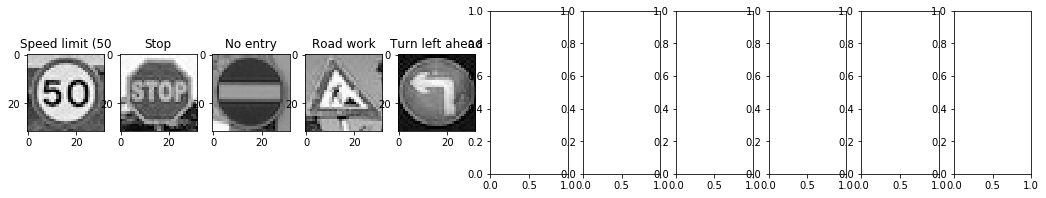

In [24]:
### Load the images and plot them here.
image_fns = [
    (2, 'examples/50_sign.jpg'),
    (34,  'examples/left_turn.jpg'),
    (17,  'examples/no_entry_sign.jpg'),
    (25,  'examples/roadworks_sign.jpg'),
    (14,  'examples/stop_sign.jpg')
]

X_unknown = np.array([plt.imread(fn) for _, fn in image_fns])
X_unknown_norm_gray = norm(gray(X_unknown))
y_unknown = np.array([id_ for id_, _ in image_fns])

show_example_all_labels(X_unknown_norm_gray, y_unknown, signnames, figsize=(18, 3))

### Predict the Sign Type for Each Image

In [25]:
### Run the predictions here and use the model to output the prediction for each image.
with tf.variable_scope(final_hyperparams['name'], reuse=None):
        #training_operation, accuracy_operation, loss_operation = get_ops(final_hyperparams)

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            saver = tf.train.Saver()
            saver.restore(sess, tf.train.latest_checkpoint('.'))

            test_accuracy, top5 = evaluate(X_unknown_norm_gray, y_unknown, 
                                     accuracy_operation, top5_operation, 
                                     final_hyperparams['batch_size'], final_hyperparams['input_channels'], 
                                     max_examples=None)
            print("Test Accuracy = {:.3f}".format(test_accuracy))
            print(top5)

INFO:tensorflow:Restoring parameters from ./final_solution_
Test Accuracy = 0.400
[TopKV2(values=array([[ 14.68442249,  10.88825703,  10.64688683,  10.14119339,   5.8382287 ],
       [  7.47037506,   7.12840033,   5.28594398,   4.1442337 ,
          3.13323379],
       [ 10.95405388,   4.48752499,   4.34921551,   4.28570557,
          3.50654817],
       [ 25.02194214,  19.56662369,  15.29801846,  13.51336002,
         13.15708542],
       [ 12.77798939,   5.13312769,   2.69752407,   2.22713184,
          2.19670892]], dtype=float32), indices=array([[38, 36,  3, 14,  2],
       [40,  8, 12, 38, 34],
       [14, 17, 12, 36, 15],
       [25, 31, 29, 21, 22],
       [14, 12, 33, 13,  3]], dtype=int32))]


### Analyze Performance

In [26]:
### Calculate the accuracy for these 5 new images. 
print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.400


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [27]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
top5_probs, top5_classes = top5[0]

def print_top5_result(expected_class, top5_prob, top5_class, signnames):
    if expected_class == top5_class[0]:
        print("CORRECT:   Image of class {} ({}) classified correctly. Top prob: {:.2f}, second probability: {:.2f}".format(
            expected_class, get_signname(expected_class, signnames), top5_prob[0], top5_prob[1]))
    elif expected_class in top5_class:
        index_of_correct_class = np.where(top5_class==expected_class)[0][0]
        print("INCORRECT: Image of class {} ({}) classified incorrectly, but correct result is top {}. "
              "Top prob: {:.2f}, correct class probability: {:.2f}".format(
                expected_class, get_signname(expected_class, signnames), index_of_correct_class + 1,
                top5_prob[0], top5_prob[index_of_correct_class]))
    else:
        print("INCORRECT: Image of class {} ({}) classified incorrectly, correct result is not within top 5. "
              "Top prob: {:.2f}, second probability: {:.2f}".format(
            expected_class, get_signname(expected_class, signnames), index_of_correct_class, 
                  top5_prob[0], top5_prob[1]))
        
for i, (expected_class, top5_probability, top5_class) in enumerate(zip(y_unknown, top5_probs, top5_classes)):
    print_top5_result(expected_class, top5_probability, top5_class, signnames)

INCORRECT: Image of class 2 (Speed limit (50km/h)) classified incorrectly, but correct result is top 5. Top prob: 14.68, correct class probability: 5.84
INCORRECT: Image of class 34 (Turn left ahead) classified incorrectly, but correct result is top 5. Top prob: 7.47, correct class probability: 3.13
INCORRECT: Image of class 17 (No entry) classified incorrectly, but correct result is top 2. Top prob: 10.95, correct class probability: 4.49
CORRECT:   Image of class 25 (Road work) classified correctly. Top prob: 25.02, second probability: 19.57
CORRECT:   Image of class 14 (Stop) classified correctly. Top prob: 12.78, second probability: 5.13


In [30]:
%ls

checkpoint                           LICENSE
CODEOWNERS                           README.md
examples/                            results.csv
final_solution_.data-00000-of-00001  set_git.sh*
final_solution.data-00000-of-00001   signnames.csv
final_solution_.index                Traffic_Sign_Classifier.ipynb*
final_solution.index                 visualize_cnn.png
final_solution_.meta                 writeup_template.md
final_solution.meta
